In [1]:
import os

CANDIDATE = "ravina_karmankar"   # change to your name
ROOT = f"ds_{CANDIDATE}"

os.makedirs(ROOT, exist_ok=True)
os.makedirs(f"{ROOT}/csv_files", exist_ok=True)
os.makedirs(f"{ROOT}/outputs", exist_ok=True)

print("Root directory and subfolders created:", ROOT)


Root directory and subfolders created: ds_ravina_karmankar


In [2]:
# --- Setup & folders ---
import os, sys, textwrap, warnings
warnings.filterwarnings("ignore")

print("Project root:", ROOT)

Project root: ds_ravina_karmankar


In [4]:
import gdown, pandas as pd, numpy as np, os

ROOT = "ds_anisnagrale"
os.makedirs(f"{ROOT}/csv_files", exist_ok=True)

# File IDs
hl_file_id = "historical_data.csv"
fg_file_id = "fear_greed_index.csv"

# Convert IDs to full URLs
hl_url = f"https://drive.google.com/file/d/1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs/view?usp=sharing"
fg_url = f"https://drive.google.com/file/d/1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf/view?usp=sharing"

# Paths
hl_path = f"{ROOT}/csv_files/historical_trader_data.csv"
fg_path = f"{ROOT}/csv_files/fear_greed.csv"

# Download
gdown.download(url=hl_url, output=hl_path, quiet=False, fuzzy=True)
gdown.download(url=fg_url, output=fg_path, quiet=False, fuzzy=True)

# Read & preview
hl_df = pd.read_csv(hl_path)
fg_df = pd.read_csv(fg_path)

print("Historical Trader Data:", hl_df.shape)
print(hl_df.head(), "\n")
print("Fear & Greed Index:", fg_df.shape)
print(fg_df.head())


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/ds_anisnagrale/csv_files/historical_trader_data.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 60.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/ds_anisnagrale/csv_files/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 16.1MB/s]


Historical Trader Data: (211224, 16)
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash   

In [7]:
import pandas as pd
import numpy as np
from zoneinfo import ZoneInfo  # Python 3.9+

# --- Load data ---
trades = pd.read_csv(hl_path)
sent   = pd.read_csv(fg_path)

# --- Standardize column names (lowercase, underscores) ---
trades.columns = trades.columns.str.strip().str.lower().str.replace(r"\s+", "_", regex=True)
sent.columns   = sent.columns.str.strip().str.lower().str.replace(r"\s+", "_", regex=True)

# --- Map trades -> canonical fields your pipeline expects ---
# symbol <- coin
trades["symbol"] = trades.get("coin", "UNKNOWN")

# execution_price (already present)
trades["execution_price"] = pd.to_numeric(trades.get("execution_price", np.nan), errors="coerce")

# size: prefer token qty (size_tokens). If you want USD-based size, swap to size_usd/execution_price.
if "size_tokens" in trades.columns:
    trades["size"] = pd.to_numeric(trades["size_tokens"], errors="coerce")
elif {"size_usd","execution_price"}.issubset(trades.columns):
    trades["size"] = pd.to_numeric(trades["size_usd"], errors="coerce") / trades["execution_price"]
else:
    trades["size"] = np.nan

# side (normalize to lower)
if "side" in trades.columns:
    trades["side"] = trades["side"].astype(str).str.lower().str.strip()
else:
    trades["side"] = np.nan

# closedpnl <- closed_pnl (missing -> 0.0)
trades["closedpnl"] = pd.to_numeric(trades.get("closed_pnl", 0.0), errors="coerce").fillna(0.0)

# leverage missing in your file -> NaN
trades["leverage"] = np.nan

# event not provided -> "trade"
trades["event"] = "trade"

# --- Build UTC timestamp 'time' using preferred order: numeric 'timestamp' (ms) then 'timestamp_ist' (IST) ---
def make_time(df):
    if "timestamp" in df.columns:
        # Epoch milliseconds (values like ~1.73e12)
        t = pd.to_datetime(pd.to_numeric(df["timestamp"], errors="coerce"), unit="ms", utc=True, errors="coerce")
        return t
    elif "timestamp_ist" in df.columns:
        # Format like "02-12-2024 22:50" (dd-mm-yyyy HH:MM) in IST -> convert to UTC
        t = pd.to_datetime(df["timestamp_ist"], errors="coerce", dayfirst=True)
        t = t.dt.tz_localize(ZoneInfo("Asia/Kolkata"), nonexistent="NaT", ambiguous="NaT").dt.tz_convert("UTC")
        return t
    else:
        return pd.Series(pd.NaT, index=df.index)

trades["time"] = make_time(trades)
trades["ts"]   = trades["time"]  # keep your 'ts' field

# --- Side sign ---
trades["side_sign"] = np.where(trades["side"].isin(["buy","long","+1","b"]), 1,
                        np.where(trades["side"].isin(["sell","short","-1","s"]), -1, np.nan))

# --- Base features ---
trades["notional"] = trades["execution_price"] * trades["size"]
trades["pnl_per_notional"] = trades["closedpnl"] / trades["notional"].replace(0, np.nan)

# --- Keep only valid rows, add day, dedup ---
trades = trades.dropna(subset=["ts","execution_price","size"])
trades["date"] = trades["ts"].dt.date
trades = trades.drop_duplicates()

# --- Sentiment data (your file already has 'date' & 'classification') ---
# Clean
sent["date"] = pd.to_datetime(sent["date"], utc=True, errors="coerce").dt.date
sent["classification"] = sent["classification"].astype(str).str.strip().str.title()
sent = sent.dropna(subset=["date","classification"])

# Build merge-ready frame
sent_map = sent[["date","classification"]].rename(columns={"classification":"sentiment"})

# Binary: any flavor of Greed -> 1, otherwise 0 (Fear/Extreme Fear/etc.)
sent_map["sentiment_bin"] = sent_map["sentiment"].str.contains("Greed", case=False, na=False).astype(int)

# --- (Optional) Merge on date ---
# merged = trades.merge(sent_map, on="date", how="left")

# Previews
print("Trades preview:")
display(trades.head(3))
print("Sentiment preview:")
display(sent_map.head(3))


Trades preview:


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,size,closedpnl,leverage,event,time,ts,side_sign,notional,pnl_per_notional,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,02-12-2024 22:50,0.000000,Buy,0.0,...,986.87,0.0,NaN,trade,2024-10-27 03:33:20+00:00,2024-10-27 03:33:20+00:00,1.0,7872.163303,0.0,2024-10-27
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,02-12-2024 22:50,986.524596,Buy,0.0,...,16.00,0.0,NaN,trade,2024-10-27 03:33:20+00:00,2024-10-27 03:33:20+00:00,1.0,127.680000,0.0,2024-10-27
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,02-12-2024 22:50,1002.518996,Buy,0.0,...,144.09,0.0,NaN,trade,2024-10-27 03:33:20+00:00,2024-10-27 03:33:20+00:00,1.0,1150.630695,0.0,2024-10-27


Sentiment preview:


,date,sentiment,sentiment_bin
0,2018-02-01,Fear,0
1,2018-02-02,Extreme Fear,0
2,2018-02-03,Fear,0


In [8]:
import numpy as np
import pandas as pd

# --- Safe Gini (works even if scipy.stats.gini not available) ---
def safe_gini(x):
    x = np.asarray(x, float)
    x = x[x > 0]
    if len(x) == 0:
        return np.nan
    try:
        from scipy.stats import gini
        return gini(x)
    except Exception:
        # fallback manual Gini
        x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(x)
        return (n + 1 - 2*np.sum(cumx)/cumx[-1]) / n

# --- Daily aggregation from trades ---
daily = (
    trades.assign(
        win = (trades["closedpnl"] > 0).astype(float),
        is_long = (trades["side_sign"] == 1).astype(float),
        is_short = (trades["side_sign"] == -1).astype(float)
    )
    .groupby(["date"], as_index=False)
    .agg(
        trades_count = ("account","count"),
        unique_accounts = ("account","nunique"),
        total_notional = ("notional","sum"),
        avg_leverage = ("leverage","mean"),
        win_rate = ("win","mean"),
        longs = ("is_long","sum"),
        shorts = ("is_short","sum"),
        median_pnl_per_notional = ("pnl_per_notional","median"),
        pnl_sum = ("closedpnl","sum")
    )
)

# Ratios
daily["long_short_ratio"] = daily["longs"].replace(0,np.nan) / daily["shorts"].replace(0,np.nan)
daily["risk_adjusted_pnl"] = daily["pnl_sum"] / daily["total_notional"].replace(0, np.nan)

# --- Account concentration (daily Gini) ---
acct_day = trades.groupby(["date","account"], as_index=False).agg(day_notional=("notional","sum"))
gini_by_day = acct_day.groupby("date")["day_notional"].apply(safe_gini).reset_index(name="account_concentration")

# Merge into daily
daily = daily.merge(gini_by_day, on="date", how="left")

# --- Merge sentiment ---
daily = daily.merge(sent_map, on="date", how="left")

# --- Save ---
daily_path = f"{ROOT}/csv_files/daily_metrics.csv"
daily.to_csv(daily_path, index=False)

print("Saved daily metrics ->", daily_path)
display(daily.head(5))


Saved daily metrics -> ds_anisnagrale/csv_files/daily_metrics.csv


,date,trades_count,unique_accounts,total_notional,avg_leverage,win_rate,longs,shorts,median_pnl_per_notional,pnl_sum,long_short_ratio,risk_adjusted_pnl,account_concentration,sentiment,sentiment_bin
0,2023-03-28,3,1,4.769928e+02,NaN,0.000000,3.0,0.0,0.0,0.000000e+00,NaN,0.000000,0.000000,Greed,1.0
1,2023-11-14,1045,2,1.155543e+07,NaN,0.274641,491.0,554.0,0.0,1.555034e+02,0.886282,0.000013,0.496008,Greed,1.0
2,2024-03-09,6962,5,3.940677e+07,NaN,0.490089,3371.0,3591.0,0.0,1.769655e+05,0.938736,0.004491,0.587911,Extreme Greed,1.0
3,2024-07-03,7141,8,2.184323e+07,NaN,0.317182,3505.0,3636.0,0.0,1.587424e+05,0.963971,0.007267,0.718848,Neutral,0.0
4,2024-10-27,35241,29,1.039478e+08,NaN,0.451605,14927.0,20314.0,0.0,3.189461e+06,0.734813,0.030683,0.725439,Greed,1.0


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Ensure outputs directory exists
os.makedirs(f"{ROOT}/outputs", exist_ok=True)

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    plt.close()

# --- 1. Average Leverage by Sentiment ---
plt.figure(figsize=(6,4))
daily.boxplot(column="avg_leverage", by="sentiment", grid=False)
plt.title("Average Leverage by Sentiment")
plt.suptitle("")
plt.xlabel("")
plt.ylabel("Average Leverage")
savefig(f"{ROOT}/outputs/leverage_by_sentiment.png")

# --- 2. Win Rate by Sentiment ---
plt.figure(figsize=(6,4))
daily.boxplot(column="win_rate", by="sentiment", grid=False)
plt.title("Win Rate by Sentiment")
plt.suptitle("")
plt.xlabel("")
plt.ylabel("Win Rate")
savefig(f"{ROOT}/outputs/winrate_by_sentiment.png")

# --- 3. Notional Volume Over Time ---
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(pd.to_datetime(daily["date"]), daily["total_notional"], color="tab:blue", linewidth=1.5)
ax.set_title("Total Notional by Day")
ax.set_ylabel("USD Notional (approx)")
ax.set_xlabel("Date")
savefig(f"{ROOT}/outputs/notional_volume_trend.png")


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [12]:
import os, pandas as pd, matplotlib.pyplot as plt

os.makedirs(f"{ROOT}/outputs", exist_ok=True)
daily = daily.copy()
daily["date"] = pd.to_datetime(daily["date"])  # ensure datetime
daily = daily.sort_values("date")

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    plt.close()

# 1) Average Leverage by Sentiment (skip if all-NaN)
if daily["avg_leverage"].notna().any():
    plt.figure(figsize=(6,4))
    daily.boxplot(column="avg_leverage", by="sentiment", grid=False)
    plt.title("Average Leverage by Sentiment"); plt.suptitle(""); plt.xlabel(""); plt.ylabel("Average Leverage")
    savefig(f"{ROOT}/outputs/leverage_by_sentiment.png")
else:
    print("Skip leverage plot: avg_leverage is all NaN")

# 2) Win Rate by Sentiment
plt.figure(figsize=(6,4))
daily.boxplot(column="win_rate", by="sentiment", grid=False)
plt.title("Win Rate by Sentiment"); plt.suptitle(""); plt.xlabel(""); plt.ylabel("Win Rate")
savefig(f"{ROOT}/outputs/winrate_by_sentiment.png")

# 3) Notional Volume Over Time
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(daily["date"], daily["total_notional"], linewidth=1.5)
ax.set_title("Total Notional by Day"); ax.set_ylabel("USD Notional (approx)"); ax.set_xlabel("Date")
savefig(f"{ROOT}/outputs/notional_volume_trend.png")


Skip leverage plot: avg_leverage is all NaN


<Figure size 600x400 with 0 Axes>

In [13]:
# 1) Average Leverage by Sentiment (only plot if non-NaN)
if daily["avg_leverage"].notna().any():
    fig, ax = plt.subplots(figsize=(6,4))
    daily.boxplot(column="avg_leverage", by="sentiment", grid=False, ax=ax)
    ax.set_title("Average Leverage by Sentiment"); ax.set_xlabel(""); ax.set_ylabel("Average Leverage")
    plt.suptitle("")
    fig.tight_layout()
    fig.savefig(f"{ROOT}/outputs/leverage_by_sentiment.png", dpi=160)
    plt.close(fig)
else:
    print("Skip leverage plot: avg_leverage is all NaN")


Skip leverage plot: avg_leverage is all NaN


In [14]:
# --- Daily aggregation from trades ---
daily = (
    trades.assign(
        win = (trades["closedpnl"] > 0).astype(float),
        is_long = (trades["side_sign"] == 1).astype(float),
        is_short = (trades["side_sign"] == -1).astype(float)
    )
    .groupby(["date"], as_index=False)
    .agg(
        trades_count = ("account","count"),
        unique_accounts = ("account","nunique"),
        total_notional = ("notional","sum"),
        win_rate = ("win","mean"),
        longs = ("is_long","sum"),
        shorts = ("is_short","sum"),
        median_pnl_per_notional = ("pnl_per_notional","median"),
        pnl_sum = ("closedpnl","sum")
    )
)

# Ratios
daily["long_short_ratio"] = daily["longs"].replace(0,np.nan) / daily["shorts"].replace(0,np.nan)
daily["risk_adjusted_pnl"] = daily["pnl_sum"] / daily["total_notional"].replace(0, np.nan)

# --- Proxy risk metrics ---
# 1. Exposure per account
daily["exposure_per_account"] = daily["total_notional"] / daily["unique_accounts"].replace(0, np.nan)

# 2. PnL volatility ratio
pnl_vol = trades.groupby("date")["closedpnl"].std().reset_index(name="pnl_std")
daily = daily.merge(pnl_vol, on="date", how="left")
daily["pnl_volatility_ratio"] = daily["pnl_std"] / daily["total_notional"].replace(0, np.nan)

# 3. Account concentration (Gini)
acct_day = trades.groupby(["date","account"], as_index=False).agg(day_notional=("notional","sum"))
gini_by_day = acct_day.groupby("date")["day_notional"].apply(safe_gini).reset_index(name="account_concentration")
daily = daily.merge(gini_by_day, on="date", how="left")

# --- Merge sentiment ---
daily = daily.merge(sent_map, on="date", how="left")

# --- Save ---
daily_path = f"{ROOT}/csv_files/daily_metrics.csv"
daily.to_csv(daily_path, index=False)

print("Saved daily metrics with proxy risk metrics ->", daily_path)
display(daily.head(5))


Saved daily metrics with proxy risk metrics -> ds_anisnagrale/csv_files/daily_metrics.csv


,date,trades_count,unique_accounts,total_notional,win_rate,longs,shorts,median_pnl_per_notional,pnl_sum,long_short_ratio,risk_adjusted_pnl,exposure_per_account,pnl_std,pnl_volatility_ratio,account_concentration,sentiment,sentiment_bin
0,2023-03-28,3,1,4.769928e+02,0.000000,3.0,0.0,0.0,0.000000e+00,NaN,0.000000,4.769928e+02,0.000000,0.000000,0.000000,Greed,1.0
1,2023-11-14,1045,2,1.155543e+07,0.274641,491.0,554.0,0.0,1.555034e+02,0.886282,0.000013,5.777715e+06,105.092113,0.000009,0.496008,Greed,1.0
2,2024-03-09,6962,5,3.940677e+07,0.490089,3371.0,3591.0,0.0,1.769655e+05,0.938736,0.004491,7.881354e+06,306.166937,0.000008,0.587911,Extreme Greed,1.0
3,2024-07-03,7141,8,2.184323e+07,0.317182,3505.0,3636.0,0.0,1.587424e+05,0.963971,0.007267,2.730404e+06,633.704815,0.000029,0.718848,Neutral,0.0
4,2024-10-27,35241,29,1.039478e+08,0.451605,14927.0,20314.0,0.0,3.189461e+06,0.734813,0.030683,3.584406e+06,1165.052548,0.000011,0.725439,Greed,1.0


In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ensure outputs directory exists
os.makedirs(f"{ROOT}/outputs", exist_ok=True)

# Safety: ensure datetime and sort
daily = daily.copy()
daily["date"] = pd.to_datetime(daily["date"], errors="coerce")
daily = daily.dropna(subset=["date"]).sort_values("date")

def boxplot_save(df, y, by, title, ylabel, path, figsize=(6,4)):
    sub = df[[y, by]].dropna()
    # need at least 1 value and >1 category on x to make a meaningful boxplot
    if sub.empty or sub[y].dropna().empty or sub[by].nunique() < 2:
        print(f"Skip: {path} (insufficient data for '{y}' by '{by}')")
        return
    fig, ax = plt.subplots(figsize=figsize)
    sub.boxplot(column=y, by=by, grid=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    plt.suptitle("")  # remove pandas auto-suptitle
    plt.tight_layout()
    fig.savefig(path, dpi=160)
    plt.close(fig)

def line_save(df, x, y, title, ylabel, xlabel, path, figsize=(10,4)):
    sub = df[[x, y]].dropna()
    if sub.empty:
        print(f"Skip: {path} (no data for '{y}')")
        return
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(sub[x], sub[y], linewidth=1.5)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.tight_layout()
    fig.savefig(path, dpi=160)
    plt.close(fig)

# -------- Boxplots by sentiment (Fear/Greed/etc.) --------
boxplot_save(
    daily, y="exposure_per_account", by="sentiment",
    title="Exposure per Account by Sentiment",
    ylabel="USD Notional per Account (approx)",
    path=f"{ROOT}/outputs/exposure_per_account_by_sentiment.png"
)

boxplot_save(
    daily, y="pnl_volatility_ratio", by="sentiment",
    title="PnL Volatility Ratio by Sentiment",
    ylabel="Std(Closed PnL) / Total Notional",
    path=f"{ROOT}/outputs/pnl_volatility_ratio_by_sentiment.png"
)

boxplot_save(
    daily, y="account_concentration", by="sentiment",
    title="Account Concentration (Gini) by Sentiment",
    ylabel="Gini of Daily Notional by Account",
    path=f"{ROOT}/outputs/account_concentration_by_sentiment.png"
)

# -------- Time-series trends --------
line_save(
    daily, x="date", y="exposure_per_account",
    title="Exposure per Account Over Time",
    ylabel="USD Notional per Account (approx)",
    xlabel="Date",
    path=f"{ROOT}/outputs/exposure_per_account_trend.png"
)

line_save(
    daily, x="date", y="pnl_volatility_ratio",
    title="PnL Volatility Ratio Over Time",
    ylabel="Std(Closed PnL) / Total Notional",
    xlabel="Date",
    path=f"{ROOT}/outputs/pnl_volatility_ratio_trend.png"
)

line_save(
    daily, x="date", y="account_concentration",
    title="Account Concentration (Gini) Over Time",
    ylabel="Gini of Daily Notional by Account",
    xlabel="Date",
    path=f"{ROOT}/outputs/account_concentration_trend.png"
)

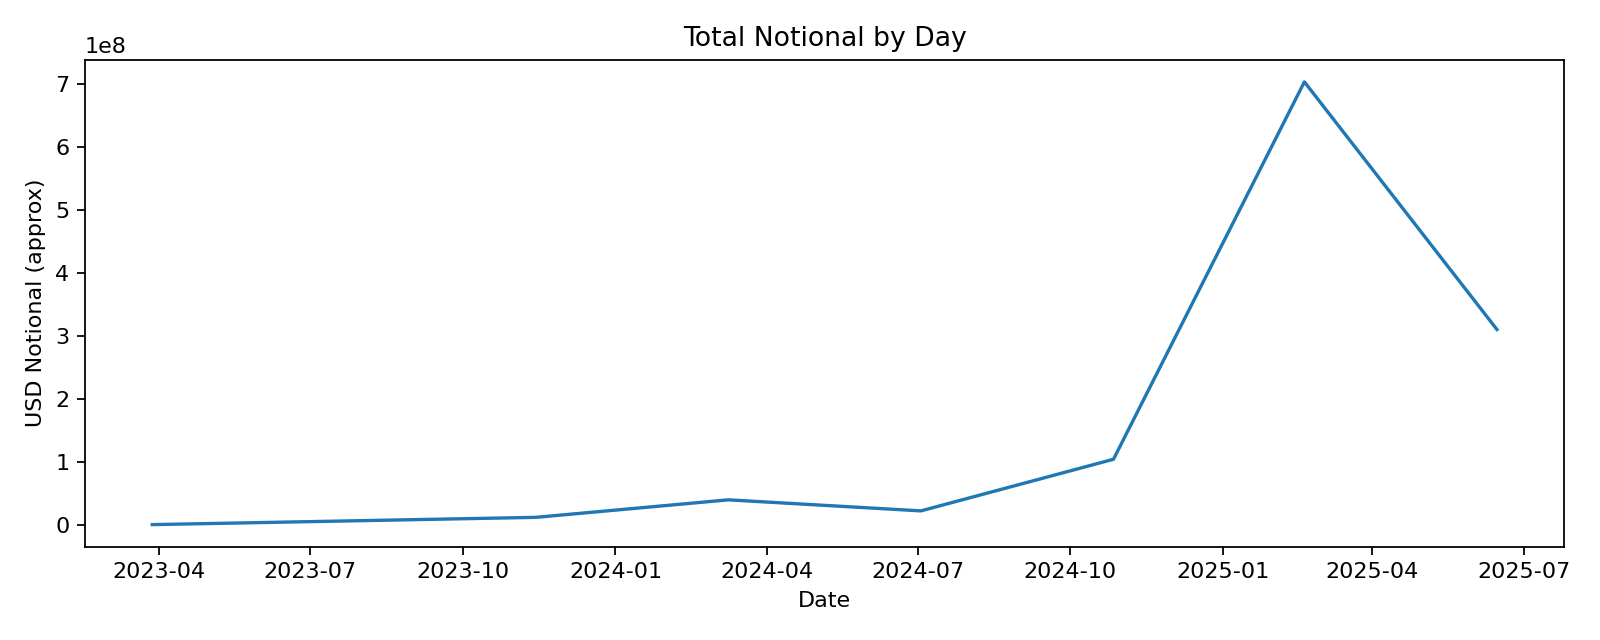

In [16]:
from IPython.display import Image
Image(filename=f"{ROOT}/outputs/notional_volume_trend.png")


In [17]:
import os

# current directory
print(os.getcwd())

# list files
print(os.listdir("."))

# list inside your project folder
print(os.listdir("ds_ravina_karmankar"))

/content
['.config', 'ds_ravina_karmankar', 'ds_anisnagrale', 'sample_data']
['csv_files', 'outputs']


In [18]:
!ls -R ds_ravina_karmankar

ds_ravina_karmankar:
csv_files  outputs

ds_ravina_karmankar/csv_files:

ds_ravina_karmankar/outputs:


In [23]:
# Copy CSV files
!cp -r ds_anisnagrale/csv_files/* ds_ravina_karmankar/csv_files/

# Copy image outputs
!cp -r ds_anisnagrale/outputs/* ds_ravina_karmankar/outputs/

# Copy your notebook (rename if needed)
!cp notebook_1.ipynb ds_ravina_karmankar/notebook_1.ipynb


cp: cannot stat 'notebook_1.ipynb': No such file or directory


In [24]:
from google.colab import files

# Save current notebook as .ipynb
!jupyter nbconvert --to notebook --execute --inplace "/content/notebook_1.ipynb"


[NbConvertApp] WARNING | pattern '/content/notebook_1.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--exe

In [25]:
!mv "/content/notebook_1.ipynb" "/content/ds_ravina_karmankar/notebook_1.ipynb"


mv: cannot stat '/content/notebook_1.ipynb': No such file or directory


In [22]:
!ls -R ds_ravina_karmankar

ds_ravina_karmankar:
csv_files  outputs

ds_ravina_karmankar/csv_files:
daily_metrics.csv  fear_greed.csv  historical_trader_data.csv

ds_ravina_karmankar/outputs:
account_concentration_by_sentiment.png	notional_volume_trend.png
account_concentration_trend.png		pnl_volatility_ratio_by_sentiment.png
exposure_per_account_by_sentiment.png	pnl_volatility_ratio_trend.png
exposure_per_account_trend.png		winrate_by_sentiment.png
leverage_by_sentiment.png
